In [61]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt


## Loading data

In [62]:
def load_mnist_csv(file_path, num_samples=None):
    df = pd.read_csv(file_path)
    labels = df.iloc[:, 0].values
    images = df.iloc[:, 1:].values
    images = images.reshape(-1, 28, 28)  # Reshape to 28x28 images

    if num_samples is not None:
        images = images[:num_samples]
        labels = labels[:num_samples]

    return images, labels

In [63]:
#Possible to load full dataset by removing the ",1000". Training with 1000 to save time.
train_images, train_labels = load_mnist_csv('/users/sami/desktop/VS Code projects/CNN from scratch/mnist_train.csv', 1000)
test_images, test_labels = load_mnist_csv('/users/sami/desktop/VS Code projects/CNN from scratch/mnist_test.csv', 1000)

## A 3x3 Convolutional Layer

In [64]:
class Conv3x3:
  # A Convolution layer using 3x3 filters.

  def __init__(self, num_filters):
    self.num_filters = num_filters

    # divide by 9 to reduce the variance of initial values
    self.filters = np.random.randn(num_filters, 3, 3) / 9

  def iterate_regions(self, image):
    h, w = image.shape

    for i in range(h - 2):
      for j in range(w - 2):
        im_region = image[i:(i + 3), j:(j + 3)]
        yield im_region, i, j

  def forward(self, input):

    self.last_input = input

    h, w = input.shape
    output = np.zeros((h - 2, w - 2, self.num_filters))

    for im_region, i, j in self.iterate_regions(input):
      output[i, j] = np.sum(im_region * self.filters, axis=(1, 2))

    return output

  def backprop(self, d_L_d_out, learn_rate):
    '''
    Performs a backward pass of the conv layer.
    - d_L_d_out is the loss gradient for this layer's outputs.
    - learn_rate is a float.
    '''
    d_L_d_filters = np.zeros(self.filters.shape)

    for im_region, i, j in self.iterate_regions(self.last_input):
      for f in range(self.num_filters):
        d_L_d_filters[f] += d_L_d_out[i, j, f] * im_region

    # Update filters
    self.filters -= learn_rate * d_L_d_filters
    
    return d_L_d_filters

## Maxpooling layer

In [65]:
class MaxPool2:
  # A Max Pooling layer using a pool size of 2.

  def iterate_regions(self, image):
 
    h, w, _ = image.shape
    new_h = h // 2
    new_w = w // 2

    for i in range(new_h):
      for j in range(new_w):
        im_region = image[(i * 2):(i * 2 + 2), (j * 2):(j * 2 + 2)]
        yield im_region, i, j

  def forward(self, input):
    self.last_input = input

    h, w, num_filters = input.shape
    output = np.zeros((h // 2, w // 2, num_filters))

    for im_region, i, j in self.iterate_regions(input):
      output[i, j] = np.amax(im_region, axis=(0, 1))

    return output

  def backprop(self, d_L_d_out):

    d_L_d_input = np.zeros(self.last_input.shape)

    for im_region, i, j in self.iterate_regions(self.last_input):
      h, w, f = im_region.shape
      amax = np.amax(im_region, axis=(0, 1))

      for i2 in range(h):
        for j2 in range(w):
          for f2 in range(f):
            if im_region[i2, j2, f2] == amax[f2]:
              d_L_d_input[i * 2 + i2, j * 2 + j2, f2] = d_L_d_out[i, j, f2]

    return d_L_d_input

## Fully Connected Layer with Softmax Layer and Xavier Initialization

In [66]:
class Softmax:
  # A standard fully-connected layer with softmax activation.
  # with Xavier Initialization
  def __init__(self, input_len, nodes):
        fan_in = input_len
        fan_out = nodes
        scale = np.sqrt(2.0 / (fan_in + fan_out))
        self.weights = np.random.randn(input_len, nodes) * scale
        self.biases = np.zeros(nodes)

  def forward(self, input):

    self.last_input_shape = input.shape

    input = input.flatten()
    self.last_input = input

    input_len, nodes = self.weights.shape

    totals = np.dot(input, self.weights) + self.biases # Linear transformation of FC layer
    self.last_totals = totals

    exp = np.exp(totals)
    return exp / np.sum(exp, axis=0)  # Softmax activation

  def backprop(self, d_L_d_out, learn_rate):
  
    for i, gradient in enumerate(d_L_d_out):
      if gradient == 0:
        continue

      # e^totals
      t_exp = np.exp(self.last_totals)

      # Sum of all e^totals
      S = np.sum(t_exp)

      # Gradients of out[i] against totals
      d_out_d_t = -t_exp[i] * t_exp / (S ** 2)
      d_out_d_t[i] = t_exp[i] * (S - t_exp[i]) / (S ** 2)

      # Gradients of totals against weights/biases/input
      d_t_d_w = self.last_input
      d_t_d_b = 1
      d_t_d_inputs = self.weights

      # Gradients of loss against totals
      d_L_d_t = gradient * d_out_d_t

      # Gradients of loss against weights/biases/input
      d_L_d_w = d_t_d_w[np.newaxis].T @ d_L_d_t[np.newaxis]
      d_L_d_b = d_L_d_t * d_t_d_b
      d_L_d_inputs = d_t_d_inputs @ d_L_d_t

      # Update weights / biases
      self.weights -= learn_rate * d_L_d_w
      self.biases -= learn_rate * d_L_d_b

      return d_L_d_inputs.reshape(self.last_input_shape)

## Forward and backward propagation

In [67]:
def forward(image, label):

  # normalization
  out = conv.forward((image / 255) - 0.5)
  out = pool.forward(out)
  out = softmax.forward(out)

  # Calculate cross-entropy loss and accuracy. np.log() is the natural log.
  loss = -np.log(out[label])
  acc = 1 if np.argmax(out) == label else 0

  return out, loss, acc

def train(im, label, optimizer, lr=.005):
  # Forward
  out, loss, acc = forward(im, label)

  # Calculate initial gradient
  gradient = np.zeros(10)
  gradient[label] = -1 / out[label]

  # Backprop
  gradient = softmax.backprop(gradient, lr)
  gradient = pool.backprop(gradient)
  grad_filters = conv.backprop(gradient, lr)
  
   # Update parameters using Adam optimizer
  optimizer.update({'filters': conv.filters}, {'filters': grad_filters})


  return loss, acc

## Adam's optimizer

In [68]:
class AdamOptimizer:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.lr = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = {}
        self.v = {}
        self.t = 0

    def update(self, params, grads):
        self.t += 1
        for key in params.keys():
            if key not in self.m:
                self.m[key] = np.zeros_like(params[key])
                self.v[key] = np.zeros_like(params[key])

            self.m[key] = self.beta1 * self.m[key] + (1 - self.beta1) * grads[key]
            self.v[key] = self.beta2 * self.v[key] + (1 - self.beta2) * (grads[key]**2)

            m_corr = self.m[key] / (1 - self.beta1**self.t)
            v_corr = self.v[key] / (1 - self.beta2**self.t)

            params[key] -= self.lr * m_corr / (np.sqrt(v_corr) + self.epsilon)


## Training the CNN

In [69]:
conv = Conv3x3(8)                  
pool = MaxPool2()                  
softmax = Softmax(13 * 13 * 8, 10) 
adam_optimizer = AdamOptimizer(learning_rate=0.001)

step_loss = []
step_accuracy = []

for epoch in range(1):
    print('--- Epoch %d ---' % (epoch + 1))
    
    loss = 0
    num_correct = 0
    for i, (im, label) in enumerate(zip(train_images, train_labels)):
        l, acc = train(im, label, adam_optimizer)
        loss += l
        num_correct += acc

        if i % 100 == 99:
            print('[Step %d] Past 100 steps: Average Loss %.3f | Accuracy: %d%%' % (i + 1, loss / 100, num_correct))
            step_loss.append(loss / 100)
            step_accuracy.append(num_correct)
            loss = 0
            num_correct = 0


--- Epoch 1 ---
[Step 100] Past 100 steps: Average Loss 2.282 | Accuracy: 13%
[Step 200] Past 100 steps: Average Loss 2.183 | Accuracy: 23%
[Step 300] Past 100 steps: Average Loss 1.823 | Accuracy: 43%
[Step 400] Past 100 steps: Average Loss 1.214 | Accuracy: 59%
[Step 500] Past 100 steps: Average Loss 1.057 | Accuracy: 66%
[Step 600] Past 100 steps: Average Loss 1.035 | Accuracy: 65%
[Step 700] Past 100 steps: Average Loss 0.881 | Accuracy: 71%
[Step 800] Past 100 steps: Average Loss 0.598 | Accuracy: 79%
[Step 900] Past 100 steps: Average Loss 0.810 | Accuracy: 74%
[Step 1000] Past 100 steps: Average Loss 0.669 | Accuracy: 82%


## Test CNN

In [70]:
# Test the CNN
print('\n--- Testing the CNN ---')
loss = 0
num_correct = 0
for im, label in zip(test_images, test_labels):
  _, l, acc = forward(im, label)
  loss += l
  num_correct += acc

num_tests = len(test_images)
print('Test Loss:', loss / num_tests)
print('Test Accuracy:', num_correct / num_tests)


--- Testing the CNN ---
Test Loss: 0.8717559087895457
Test Accuracy: 0.688


## Prediction visualization

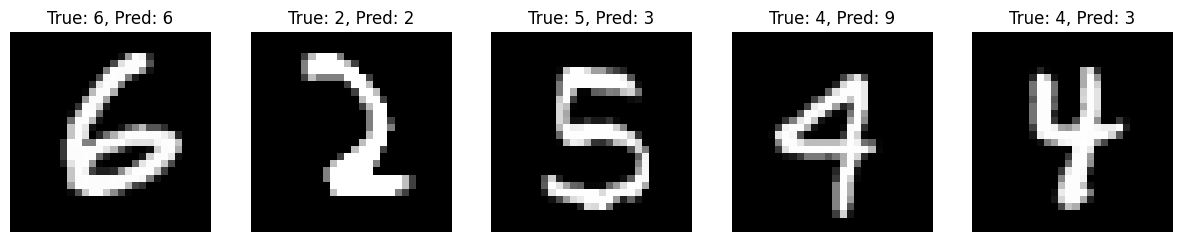

In [71]:
num_samples = 5
samples = np.random.choice(len(test_images), num_samples, replace=False)

plt.figure(figsize=(15, 5))
for i, index in enumerate(samples):
    image, true_label = test_images[index], test_labels[index]
    predicted_output, _, _ = forward(image, true_label)
    predicted_label = np.argmax(predicted_output)

    plt.subplot(1, num_samples, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"True: {true_label}, Pred: {predicted_label}")
    plt.axis('off')

plt.show()


## Accuracy and Loss graphs

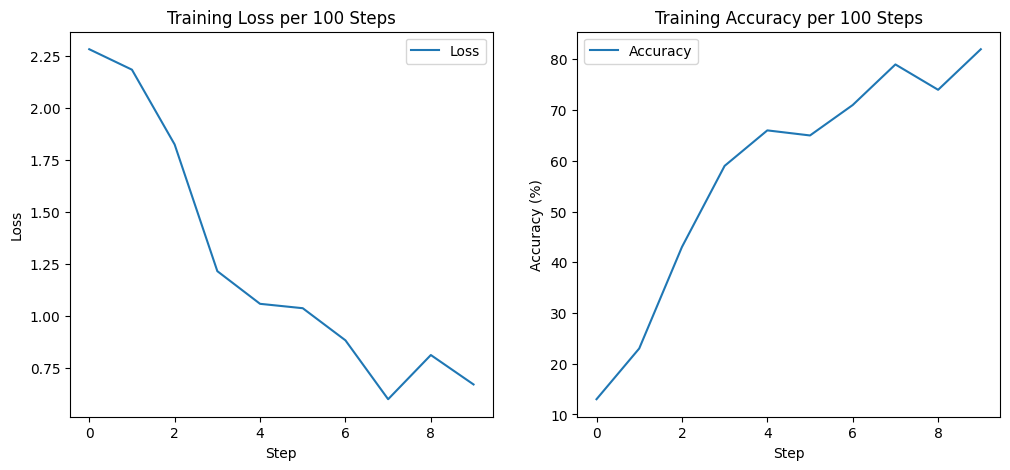

In [72]:
# Plotting Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(step_loss, label='Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss per 100 Steps')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(step_accuracy, label='Accuracy')
plt.xlabel('Step')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy per 100 Steps')
plt.legend()

plt.show()
